In [1]:
# Enable inline plotting for notebooks
%matplotlib inline

GO BP terms loaded: 1,095
Min term size: 5
Max term size: 243
Unique ORFs across all terms: 4,927


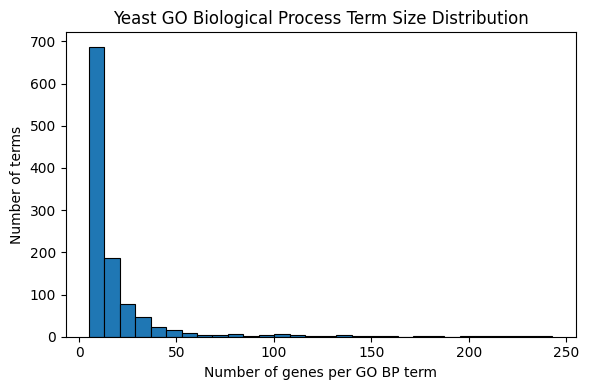

In [18]:
# Loads pre-filtered GO BP annotations and visualizes term sizes.
import json
from pathlib import Path

import matplotlib.pyplot as plt

DATA_DIR = Path("data/yeast")
GO_BP_PATH = DATA_DIR / "go_bp_name_to_orfs.json"

# Load GO Biological Process term → ORF mapping (already filtered upstream)
with GO_BP_PATH.open("r", encoding="utf-8") as fh:
    go_bp = json.load(fh)

# Compute term sizes and global ORF coverage
term_sizes = [len(set(orfs)) for orfs in go_bp.values()]
all_orfs = {orf for orfs in go_bp.values() for orf in orfs}

# Summary statistics reported in the manuscript
print(f"GO BP terms loaded: {len(term_sizes):,}")
print(f"Min term size: {min(term_sizes)}")
print(f"Max term size: {max(term_sizes)}")
print(f"Unique ORFs across all terms: {len(all_orfs):,}")

# Histogram of GO BP term sizes
plt.figure(figsize=(6, 4))
plt.hist(
    term_sizes,
    bins=30,
    edgecolor="black",
    linewidth=0.8,
)
plt.xlabel("Number of genes per GO BP term")
plt.ylabel("Number of terms")
plt.title("Yeast GO Biological Process Term Size Distribution")
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

MATRIX_PATH = DATA_DIR / "gi_score_sampled.tsv"

# Load GI PCC matrix (ORF x ORF)
DF_GI_SCORE = pd.read_csv(
    MATRIX_PATH,
    sep="\t",
    index_col=0,
)

# Sanity checks
print(f"Matrix shape: {DF_GI_SCORE.shape[0]:,} × {DF_GI_SCORE.shape[1]:,}")
print(f"Row/column labels identical: {DF_GI_SCORE.index.equals(DF_GI_SCORE.columns)}")
print(f"Value range: [{DF_GI_SCORE.min().min():.3f}, {DF_GI_SCORE.max().max():.3f}]")

display(DF_GI_SCORE.head())

Matrix shape: 1,142 × 1,142
Row/column labels identical: False
Value range: [-1.095, 1.478]


,YNL243W,YMR030W-A,YLR275W,YDR302W,YJL031C,YGL116W,YPL069C,YEL034W,YLR310C,YLR268W,...,YLL023C,YNR010W,YGL170C,YGR245C,YGL216W,YER156C,YCR003W,YGR197C,YMR033W,YJR140C
Query Gene,,,,,,,,,,,,,,,,,,,,,
YNL243W,0.0000,0.0000,0.0,-0.3112,0.0000,0.0961,-0.5364,0.0000,0.1149,0.0000,...,0.0000,0.0,0.0,0.33430,0.0000,0.00000,0.0,0.0,0.0000,0.0000
YMR030W-A,0.0000,0.0000,0.0,-0.2963,0.0000,0.0000,0.0491,0.0000,0.0000,-0.0702,...,0.0000,0.0,0.0,0.00000,0.0000,0.00000,0.0,0.0,0.0000,0.0000
YLR275W,0.0000,0.0000,0.0,0.0000,0.0000,-0.1608,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.0,0.14550,-0.1491,0.00000,0.0,0.0,0.3374,-0.4909
YDR302W,-0.3112,-0.2963,0.0,0.0000,0.2026,-0.0654,0.1986,0.2527,0.1218,0.0000,...,-0.5064,0.0,0.0,-0.11140,0.0000,0.00000,0.0,0.0,-0.3312,0.0000
YJL031C,0.0000,0.0000,0.0,0.2026,0.0000,0.1558,-0.5182,0.0000,0.0000,-0.2886,...,0.0000,0.0,0.0,0.20115,0.0000,0.10275,0.0,0.0,-0.1536,0.0000


In [20]:
import json
from pathlib import Path

# Authoritative gene order from matrix
genes = DF_GI_SCORE.index

# ============================================================
# Helper functions
# ============================================================


def build_binary_gene_map(
    genes,
    positive_set,
    pos_label,
    neg_label,
):
    """Return {gene -> pos_label/neg_label} based on membership in positive_set."""
    return {gene: (pos_label if gene in positive_set else neg_label) for gene in genes}


def load_essential_orfs(path):
    """Load one ORF per line."""
    return {line.strip() for line in path.read_text().splitlines() if line.strip()}


def load_uncharacterized_orfs(path):
    """Load uncharacterized ORFs from a JSON object keyed by ORF."""
    with path.open() as f:
        return set(json.load(f).keys())


def map_essential_genes(genes, essential_orfs):
    """Map genes to essential/nonessential labels and return label->color mapping."""
    gene_map = build_binary_gene_map(
        genes,
        essential_orfs,
        pos_label="essential",
        neg_label="nonessential",
    )

    colors = {
        "essential": "#d73027",  # red
        "nonessential": "black",
    }

    return gene_map, colors


def map_uncharacterized_genes(
    genes,
    uncharacterized_orfs,
    *,
    pos_label="uncharacterized",
    neg_label="characterized",
):
    """Map genes to uncharacterized/characterized labels and return label->color mapping."""
    gene_map = build_binary_gene_map(
        genes,
        uncharacterized_orfs,
        pos_label=pos_label,
        neg_label=neg_label,
    )

    colors = {
        pos_label: "dodgerblue",
        neg_label: "black",
    }

    return gene_map, colors


# ============================================================
# Execution / calls
# ============================================================

# ------------------------------------------------------------
# Essential genes
# ------------------------------------------------------------

essential_path = DATA_DIR / "yeast_essential_orfs.txt"
essential_orfs = load_essential_orfs(essential_path)

gene_essential_map, gene_essential_colors = map_essential_genes(genes, essential_orfs)

print("Total genes:", len(genes))
print(
    "Essential in matrix:",
    sum(v == "essential" for v in gene_essential_map.values()),
)

# ------------------------------------------------------------
# Characterization status (authoritative: JSON keys only)
# ------------------------------------------------------------

unchar_path = DATA_DIR / "yeast_uncharacterized_orfs.json"
uncharacterized_orfs = load_uncharacterized_orfs(unchar_path)

gene_characterization_map, gene_characterization_colors = map_uncharacterized_genes(
    genes,
    uncharacterized_orfs,
)

print(
    "Uncharacterized ORFs in matrix:",
    sum(v == "uncharacterized" for v in gene_characterization_map.values()),
)

Total genes: 1142
Essential in matrix: 510
Uncharacterized ORFs in matrix: 5


In [23]:
from himalayas import Matrix, Annotations, Analysis
from himalayas.text import summarize_clusters

LINKAGE_THRESHOLD = 8

# Build core objects
matrix = Matrix(DF_GI_SCORE)
annotations = Annotations(go_bp, matrix)

# Run clustering + enrichment
analysis = (
    Analysis(matrix, annotations)
    .cluster(
        linkage_method="ward",
        linkage_metric="euclidean",
        linkage_threshold=LINKAGE_THRESHOLD,
        min_cluster_size=26,
    )
    .enrich(min_overlap=2)
    .finalize(
        col_cluster=True,
        add_qvalues=True,
    )
)

results = analysis.results
# Keep significant terms
results_sig = results.filter("qval <= 0.05")

# Summarize clusters for plotting
cluster_labels = summarize_clusters(
    results_sig.df,
    label_mode="top_term",
    term_col="term",
)

print(f"All enriched rows: {len(results.df):,}")
print(f"Significant rows (q<=0.05): {len(results_sig.df):,}")
print(cluster_labels)

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 190/1095 annotations with no overlap to matrix labels
  warn(


All enriched rows: 984
Significant rows (q<=0.05): 464
    cluster                                              label          pval
0         1      transcription elongation by RNA polymerase II  3.571865e-14
1         2                       protein targeting to vacuole  2.121948e-11
2         3                          mitochondrial translation  1.058297e-09
3         4                    ergosterol biosynthetic process  1.491873e-09
4         5                                mitotic cytokinesis  6.025786e-07
5         6                                ribosome biogenesis  2.468081e-36
6         7                                       RNA splicing  3.174609e-61
7         8  proteasome-mediated ubiquitin-dependent protei...  4.349260e-39
8         9                                    DNA replication  2.992794e-38
9        10                             chromosome segregation  1.334506e-19
10       11  endoplasmic reticulum to Golgi vesicle-mediate...  1.897195e-31
11       12          

In [22]:
# ============================================================
# Colormap for -log10(p-value) in range [0, max]
# ============================================================

import numpy as np
from matplotlib.colors import LinearSegmentedColormap


def make_diverging_cmap(
    neg="#2166ac",
    mid="#f7f7f7",
    pos="#fdd835",
    name="BlueWhiteYellow",
    N=256,
):
    """
    Create a diverging colormap with a neutral midpoint.

    Colors are specified in visual space only.
    Data centering must be handled by a normalization (e.g. TwoSlopeNorm).

    Returns
    -------
    matplotlib.colors.LinearSegmentedColormap
    """
    return LinearSegmentedColormap.from_list(
        name,
        [(0.0, neg), (0.5, mid), (1.0, pos)],
        N=N,
    )


# Use the standardized diverging colormap helper (blue → white → yellow)
matrix_cmap = make_diverging_cmap(
    neg="#2b7cff",  # vivid electric blue
    mid="#000000",  # true black
    pos="#ffd400",  # high-luminance yellow
    name="BlueBlackYellow",
)

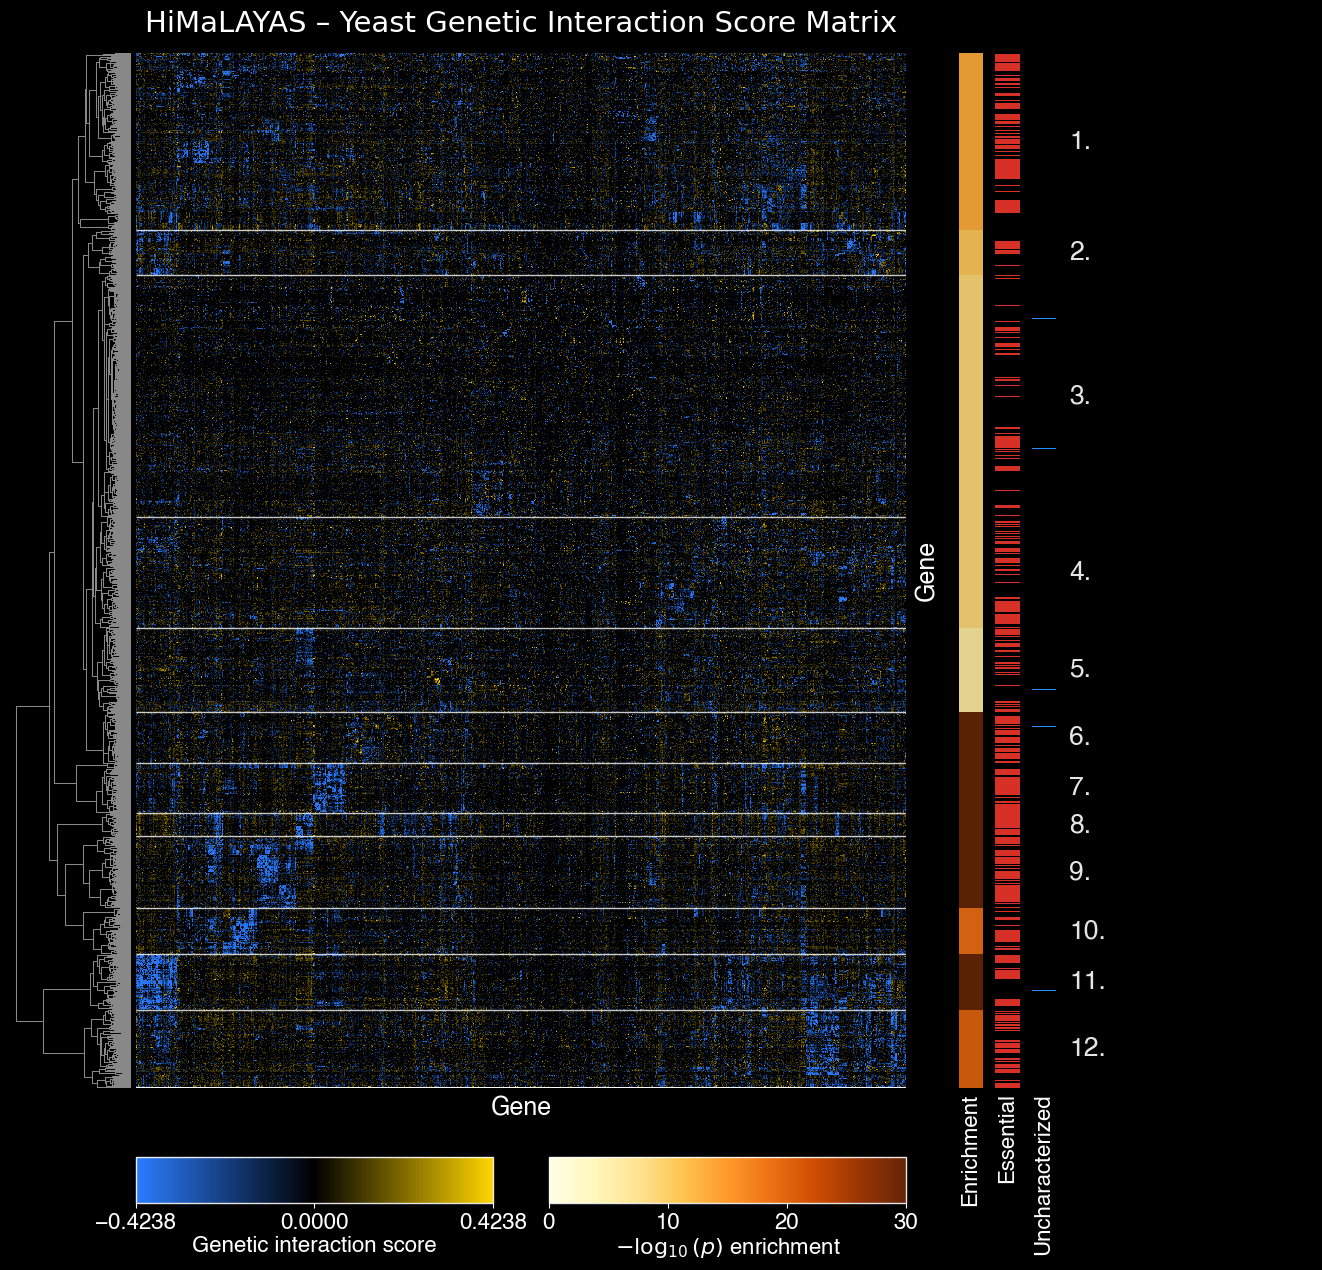

In [8]:
import numpy as np

from matplotlib.colors import Normalize

from himalayas.plot import Plotter

LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"
FONT = "Helvetica"

vals = matrix.values
mask = np.isfinite(vals) & (vals != 0)
vlim = float(np.percentile(np.abs(vals[mask]), 98))

plotter = (
    Plotter(results)
    .set_background(color=BACKGROUND_COLOR)
    .plot_title(
        "HiMaLAYAS – Yeast Genetic Interaction Score Matrix",
        color=LABEL_COLOR,
        fontsize=21,
    )
    .plot_dendrogram(
        axes=[0.06, 0.05, 0.09, 0.90],
        data_pad=0.75,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap=matrix_cmap,
        center=0,
        vmin=-vlim,
        vmax=vlim,
        outer_lw=0,
        figsize=(14, 11.5),
        subplots_adjust={"left": 0.15, "right": 0.70, "bottom": 0.05, "top": 0.95},
    )
    .plot_matrix_axis_labels(
        xlabel="Gene",
        ylabel="Gene",
        fontsize=18,
        font=FONT,
        color=LABEL_COLOR,
        xlabel_pad=6.0,
        ylabel_pad=0.008,
    )
    .plot_cluster_bar(
        norm=Normalize(0, 30),
        name="sigbar",
        title="Enrichment",
        values=cluster_labels,
        pval_col="pval",
        width=0.06,
        left_pad=0.1,
        right_pad=0.00,
    )
    .plot_cluster_labels(
        cluster_labels,
        max_words=4,
        wrap_text=True,
        wrap_width=40,
        overflow="wrap",
        font=FONT,
        fontsize=19,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "p"),
        omit_words={},
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color=LABEL_COLOR,
        label_sep_lw=1,
        label_sep_alpha=0.0,
        label_gutter_color=BACKGROUND_COLOR,
        overrides={
            1: "1.",
            2: "2.",
            3: "3.",
            4: "4.",
            5: "5.",
            6: "6.",
            7: "7.",
            8: "8.",
            9: "9.",
            10: "10.",
            11: "11.",
            12: "12.",
        },
        axes=[0.70, 0.05, 0.29, 0.90],
    )
    .plot_gene_bar(
        values=gene_essential_map,
        mode="categorical",
        colors=gene_essential_colors,
        placement="label_panel",
        gene_bar_left_pad=0.03,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.00,
        name="essentiality",
        title="Essential",
    )
    .plot_gene_bar(
        values=gene_characterization_map,
        mode="categorical",
        colors=gene_characterization_colors,
        placement="label_panel",
        gene_bar_left_pad=0.03,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.02,
        name="characterization",
        title="Uncharacterized",
    )
    .plot_bar_labels(
        font=FONT,
        fontsize=16,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .set_label_track_order(("sigbar", "essentiality", "characterization"))
    .add_colorbar(
        name="matrix",
        cmap=matrix_cmap,
        norm=Normalize(-vlim, vlim),
        label="Genetic interaction score",
        ticks=[-vlim, 0, vlim],
    )
    .add_colorbar(
        name="enrichment",
        cmap="YlOrBr",
        norm=Normalize(0, 30),
        label=r"$-\log_{10}(p)$ enrichment",
        ticks=[0, 10, 20, 30],
    )
    .plot_colorbars(
        ncols=2,
        height=0.04,
        gap=0.06,
        hpad=0.04,
        vpad=0.00,
        fontsize=16,
        font=FONT,
        color=LABEL_COLOR,
        border_color=LABEL_COLOR,
        border_width=1.0,
        border_alpha=0.9,
    )
)

# plotter.save('test.png', bbox_inches='tight')
plotter.show()

In [24]:
# ============================================================
# HiMaLAYAS — Cluster-specific zoom analysis (full workflow)
# ============================================================

# ------------------------------------------------------------
# Hierarchical clustering options (quick reference)
# ------------------------------------------------------------
#
# linkage_method:
#   - "ward"      : compact, variance-minimizing clusters (requires euclidean)
#   - "average"   : average pairwise distance between clusters
#   - "complete"  : maximum pairwise distance (tight clusters)
#   - "single"    : minimum pairwise distance (chaining; usually discouraged)
#
# linkage_metric:
#   - "euclidean"   : required for ward; default and safest
#   - "correlation" : distance = 1 − Pearson correlation
#   - "cosine"      : angle-based similarity
#   - "cityblock"   : Manhattan distance
#
# Recommended default:
#   linkage_method="ward"
#   linkage_metric="euclidean"
# ------------------------------------------------------------


def run_zoom_analysis(
    *,
    results,
    cluster_id,
    go_bp,
    linkage_threshold,
    min_cluster_size=6,
    min_overlap=2,
    qval_cutoff=0.05,
):
    zoom_view = results.subset(cluster=cluster_id)
    zoom_matrix = zoom_view.matrix
    zoom_annotations = Annotations(
        go_bp,
        zoom_matrix,
    )
    zoom_analysis = (
        Analysis(zoom_matrix, zoom_annotations)
        .cluster(
            linkage_method="ward",
            linkage_metric="euclidean",
            linkage_threshold=linkage_threshold,
            min_cluster_size=min_cluster_size,
        )
        .enrich(
            min_overlap=min_overlap,
            background=results.matrix,
        )
        .finalize(
            col_cluster=True,
            add_qvalues=True,
        )
    )
    zoom_results = zoom_analysis.results
    zoom_results_sig = zoom_results.filter(f"qval <= {qval_cutoff}")
    zoom_cluster_labels = summarize_clusters(
        zoom_results_sig.df,
        label_mode="top_term",
        label_col="term",
    )
    return zoom_matrix, zoom_results, zoom_results_sig, zoom_cluster_labels

In [26]:
CLUSTER_ID = 7
ZOOM_LINKAGE_THRESHOLD = 6

zoom_matrix, zoom_results, zoom_results_sig, zoom_cluster_labels = run_zoom_analysis(
    results=results,
    cluster_id=CLUSTER_ID,
    go_bp=go_bp,
    linkage_threshold=ZOOM_LINKAGE_THRESHOLD,
)

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 1039/1095 annotations with no overlap to matrix labels
  warn(


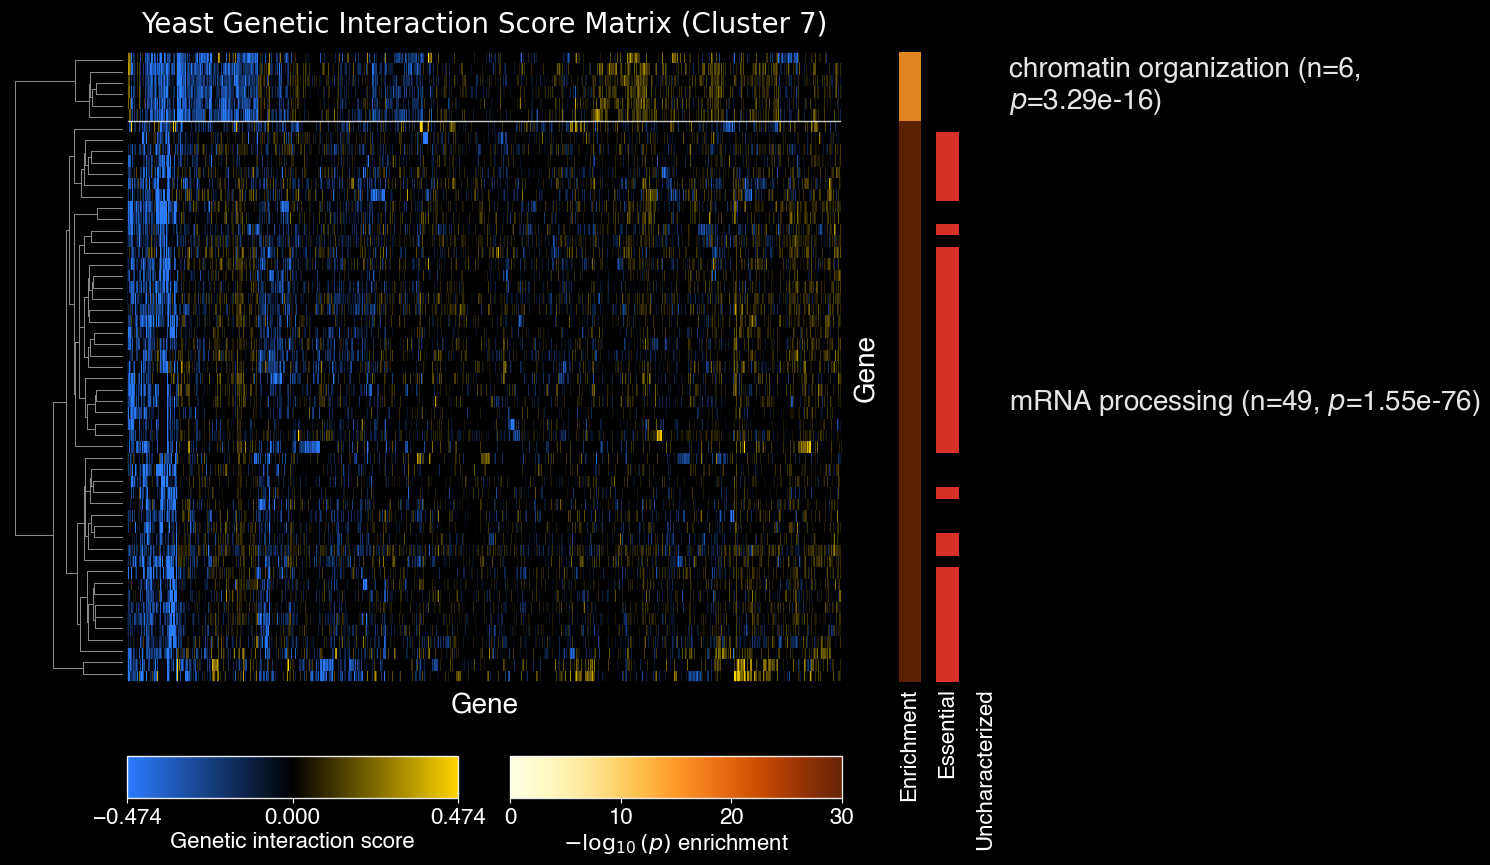

In [27]:
# Universal colors
LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"

# Robust heatmap scaling
vals = zoom_matrix.values
mask = np.isfinite(vals) & (vals != 0)
vlim = float(np.percentile(np.abs(vals[mask]), 98))

# Create the plotter with your enrichment results
plotter = Plotter(zoom_results)

(
    plotter.set_background(color=BACKGROUND_COLOR)
    .plot_title(
        f"Yeast Genetic Interaction Score Matrix (Cluster {CLUSTER_ID})",
        color=LABEL_COLOR,
        fontsize=20,
    )
    .plot_dendrogram(
        axes=[0.06, 0.05, 0.09, 0.90],
        data_pad=0.75,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap=matrix_cmap,
        center=0,
        vmin=-vlim,
        vmax=vlim,
        figsize=(13, 7),
        subplots_adjust={
            "left": 0.15,
            "right": 0.70,
            "bottom": 0.05,
            "top": 0.95,
        },
    )
    .plot_matrix_axis_labels(
        xlabel="Gene",
        ylabel="Gene",
        font=FONT,
        fontsize=20,
        color=LABEL_COLOR,
        xlabel_pad=8,
        ylabel_pad=0.012,
    )
    .plot_cluster_bar(
        norm=Normalize(0, 30),
        name="sigbar",
        title="Enrichment",
        values=zoom_cluster_labels,
        pval_col="pval",
        width=0.06,
        left_pad=0.12,
        right_pad=0.00,
    )
    .plot_cluster_labels(
        zoom_cluster_labels,
        max_words=24,
        wrap_text=True,  # enable wrapping
        wrap_width=40,  # characters per line (tune if needed)
        overflow="wrap",  # never ellipsize
        font=FONT,
        fontsize=20,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "n", "p"),
        omit_words={},
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color="#bbbbbb",
        label_sep_lw=1,
        label_sep_alpha=0.0,
        label_gutter_color=BACKGROUND_COLOR,
        axes=[0.70, 0.05, 0.29, 0.90],
    )
    .plot_gene_bar(
        values=gene_essential_map,
        mode="categorical",
        colors=gene_essential_colors,
        placement="label_panel",
        gene_bar_left_pad=0.04,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.00,
        name="essentiality",
        title="Essential",
    )
    .plot_gene_bar(
        values=gene_characterization_map,
        mode="categorical",
        colors=gene_characterization_colors,
        placement="label_panel",
        gene_bar_left_pad=0.04,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.02,
        name="unchar",
        title="Uncharacterized",
    )
    .plot_bar_labels(
        font=FONT,
        fontsize=16,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .set_label_track_order(("sigbar", "essentiality", "unchar"))
    .add_colorbar(
        name="matrix",
        cmap=matrix_cmap,
        norm=Normalize(-vlim, vlim),
        label="Genetic interaction score",
        ticks=[-vlim, 0, vlim],
    )
    .add_colorbar(
        name="enrichment",
        cmap="YlOrBr",
        norm=Normalize(0, 30),
        label=r"$-\log_{10}(p)$ enrichment",
        ticks=[0, 10, 20, 30],
    )
    .plot_colorbars(
        ncols=2,
        height=0.06,
        gap=0.105,
        hpad=0.04,
        vpad=0.00,
        fontsize=16,
        font=FONT,
        color=LABEL_COLOR,
        border_color=LABEL_COLOR,
        border_width=1.0,
        border_alpha=0.9,
    )
    .show()
)

In [28]:
CLUSTER_ID = 8
ZOOM_LINKAGE_THRESHOLD = 5

zoom_matrix, zoom_results, zoom_results_sig, zoom_cluster_labels = run_zoom_analysis(
    results=results,
    cluster_id=CLUSTER_ID,
    go_bp=go_bp,
    linkage_threshold=ZOOM_LINKAGE_THRESHOLD,
)

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 1062/1095 annotations with no overlap to matrix labels
  warn(


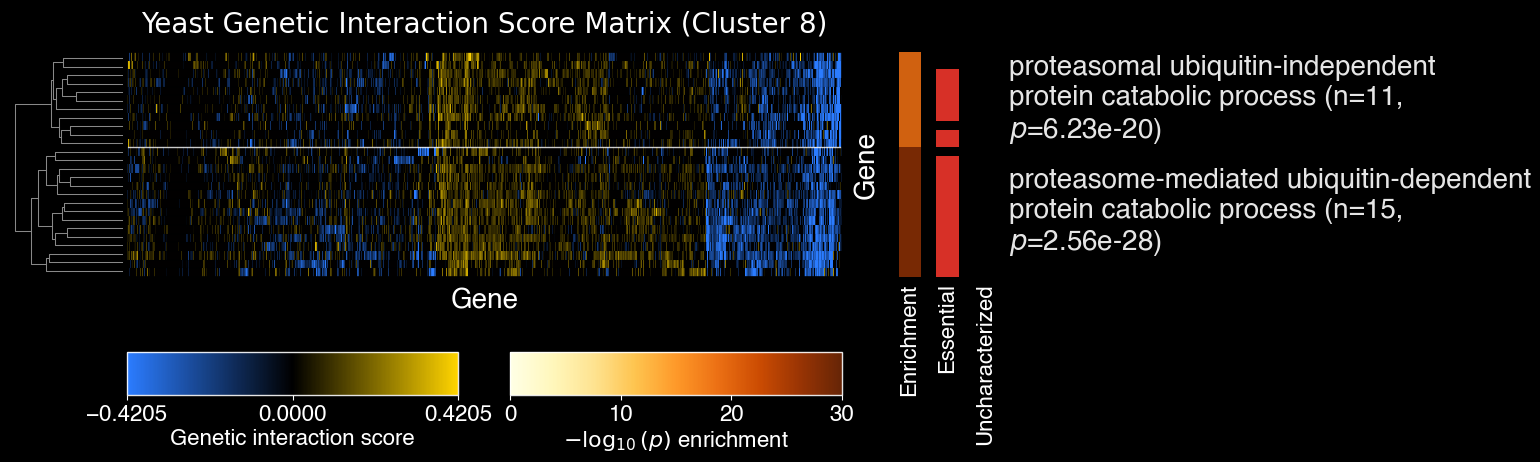

In [29]:
# ============================================================
# Step 7: Plot zoomed clustered matrix
# ============================================================

# Robust heatmap scaling
vals = zoom_matrix.values
mask = np.isfinite(vals) & (vals != 0)
if not np.any(mask):
    raise ValueError("Matrix has no finite nonzero entries for heatmap scaling")
vlim = float(np.percentile(np.abs(vals[mask]), 98))

# Universal colors
LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"

# Create the plotter with your enrichment results
plotter = Plotter(zoom_results)

(
    plotter.set_background(color=BACKGROUND_COLOR)
    .plot_title(
        f"Yeast Genetic Interaction Score Matrix (Cluster {CLUSTER_ID})",
        color=LABEL_COLOR,
        fontsize=20,
    )
    .plot_dendrogram(
        axes=[0.06, 0.05, 0.09, 0.90],
        data_pad=0.75,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap=matrix_cmap,
        center=0,
        vmin=-vlim,
        vmax=vlim,
        figsize=(13, 2.5),
        subplots_adjust={
            "left": 0.15,
            "right": 0.70,
            "bottom": 0.05,
            "top": 0.95,
        },
    )
    .plot_matrix_axis_labels(
        xlabel="Gene",
        ylabel="Gene",
        font=FONT,
        fontsize=20,
        color=LABEL_COLOR,
        xlabel_pad=8,
        ylabel_pad=0.012,
    )
    .plot_cluster_labels(
        zoom_cluster_labels,
        max_words=24,
        wrap_text=True,  # enable wrapping
        wrap_width=40,  # characters per line (tune if needed)
        overflow="wrap",  # never ellipsize
        font="Helvetica",
        fontsize=20,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "n", "p"),
        omit_words={},
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color="#bbbbbb",
        label_sep_lw=1,
        label_sep_alpha=0.0,
        label_gutter_color=BACKGROUND_COLOR,
        axes=[0.70, 0.05, 0.29, 0.90],
    )
    .plot_cluster_bar(
        norm=Normalize(0, 30),
        name="sigbar",
        title="Enrichment",
        values=zoom_cluster_labels,
        pval_col="pval",
        width=0.06,
        left_pad=0.12,
        right_pad=0.00,
    )
    .plot_gene_bar(
        values=gene_essential_map,
        mode="categorical",
        colors=gene_essential_colors,
        placement="label_panel",
        gene_bar_left_pad=0.04,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.00,
        name="essentiality",
        title="Essential",
    )
    .plot_gene_bar(
        values=gene_characterization_map,
        mode="categorical",
        colors=gene_characterization_colors,
        placement="label_panel",
        gene_bar_left_pad=0.04,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.02,
        name="unchar",
        title="Uncharacterized",
    )
    .plot_bar_labels(
        font="Helvetica",
        fontsize=16,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .set_label_track_order(("sigbar", "essentiality", "unchar"))
    .add_colorbar(
        name="matrix",
        cmap=matrix_cmap,
        norm=Normalize(-vlim, vlim),
        label="Genetic interaction score",
        ticks=[-vlim, 0, vlim],
    )
    .add_colorbar(
        name="enrichment",
        cmap="YlOrBr",
        norm=Normalize(0, 30),
        label=r"$-\log_{10}(p)$ enrichment",
        ticks=[0, 10, 20, 30],
    )
    .plot_colorbars(
        ncols=2,
        height=0.17,
        gap=0.3,
        hpad=0.04,
        vpad=0.00,
        fontsize=16,
        font="Helvetica",
        color=LABEL_COLOR,
        border_color=LABEL_COLOR,
        border_width=1.0,
        border_alpha=0.9,
    )
    .show()
)

In [30]:
CLUSTER_ID = 9
ZOOM_LINKAGE_THRESHOLD = 6

zoom_matrix, zoom_results, zoom_results_sig, zoom_cluster_labels = run_zoom_analysis(
    results=results,
    cluster_id=CLUSTER_ID,
    go_bp=go_bp,
    linkage_threshold=ZOOM_LINKAGE_THRESHOLD,
)

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 932/1095 annotations with no overlap to matrix labels
  warn(


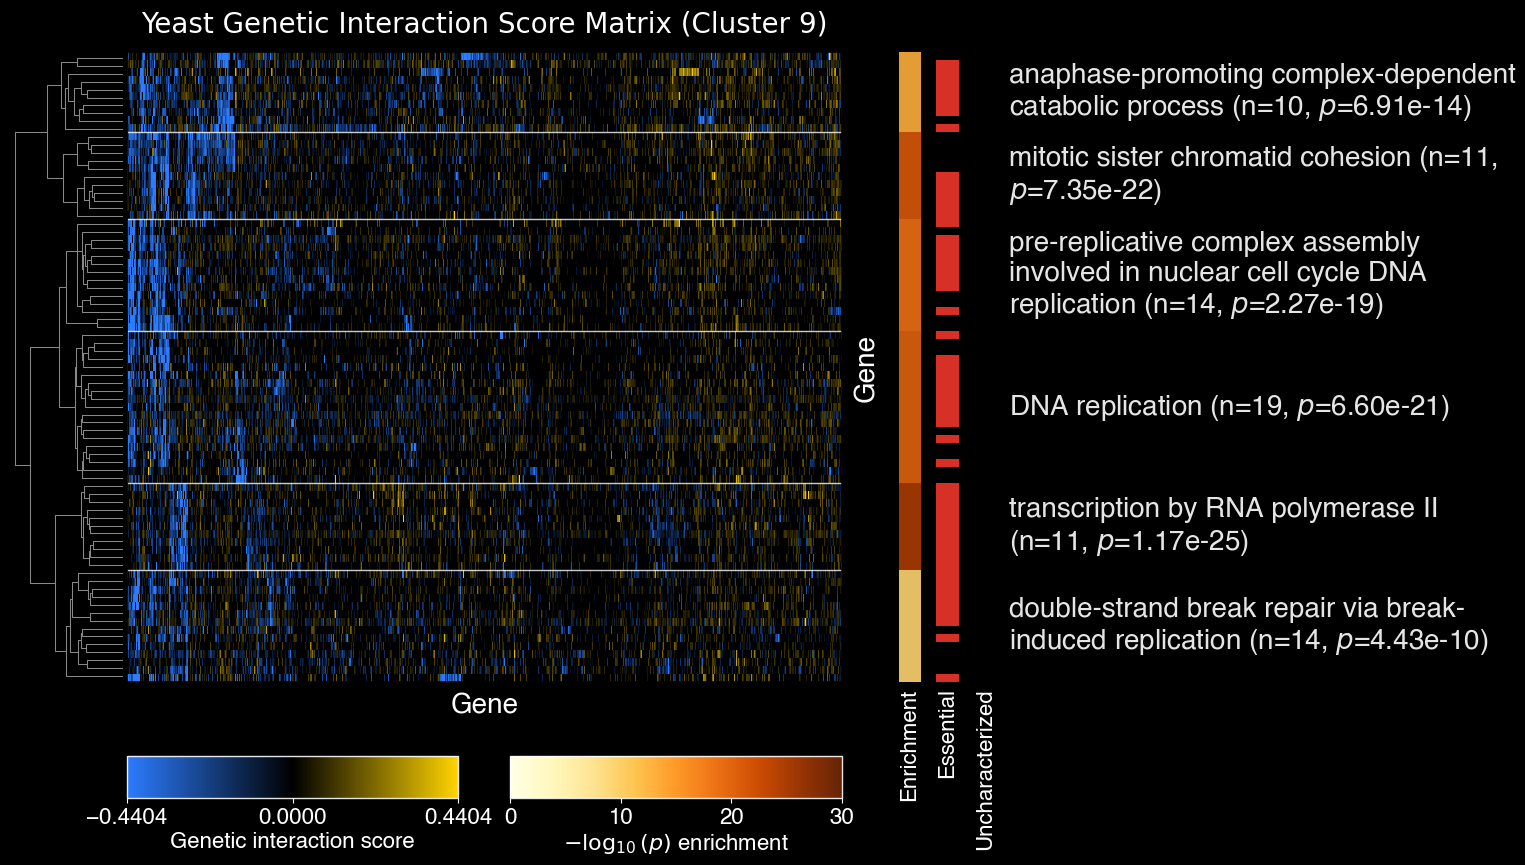

In [31]:
# ============================================================
# Step 7: Plot zoomed clustered matrix
# ============================================================

# Robust heatmap scaling
vals = zoom_matrix.values
mask = np.isfinite(vals) & (vals != 0)
if not np.any(mask):
    raise ValueError("Matrix has no finite nonzero entries for heatmap scaling")
vlim = float(np.percentile(np.abs(vals[mask]), 98))

# Universal colors
LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"

# Create the plotter with your enrichment results
plotter = Plotter(zoom_results)

(
    plotter.set_background(color=BACKGROUND_COLOR)
    .plot_title(
        f"Yeast Genetic Interaction Score Matrix (Cluster {CLUSTER_ID})",
        color=LABEL_COLOR,
        fontsize=20,
    )
    .plot_dendrogram(
        axes=[0.06, 0.05, 0.09, 0.90],
        data_pad=0.75,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap=matrix_cmap,
        center=0,
        vmin=-vlim,
        vmax=vlim,
        figsize=(13, 7),
        subplots_adjust={
            "left": 0.15,
            "right": 0.70,
            "bottom": 0.05,
            "top": 0.95,
        },
    )
    .plot_matrix_axis_labels(
        xlabel="Gene",
        ylabel="Gene",
        font=FONT,
        fontsize=20,
        color=LABEL_COLOR,
        xlabel_pad=8,
        ylabel_pad=0.012,
    )
    .plot_cluster_labels(
        zoom_cluster_labels,
        max_words=24,
        wrap_text=True,  # enable wrapping
        wrap_width=40,  # characters per line (tune if needed)
        overflow="wrap",  # never ellipsize
        font="Helvetica",
        fontsize=20,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "n", "p"),
        omit_words={},
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color="#bbbbbb",
        label_sep_lw=1,
        label_sep_alpha=0.0,
        label_gutter_color=BACKGROUND_COLOR,
        axes=[0.70, 0.05, 0.29, 0.90],
    )
    .plot_cluster_bar(
        norm=Normalize(0, 30),
        name="sigbar",
        title="Enrichment",
        values=zoom_cluster_labels,
        pval_col="pval",
        width=0.06,
        left_pad=0.12,
        right_pad=0.00,
    )
    .plot_gene_bar(
        values=gene_essential_map,
        mode="categorical",
        colors=gene_essential_colors,
        placement="label_panel",
        gene_bar_left_pad=0.04,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.00,
        name="essentiality",
        title="Essential",
    )
    .plot_gene_bar(
        values=gene_characterization_map,
        mode="categorical",
        colors=gene_characterization_colors,
        placement="label_panel",
        gene_bar_left_pad=0.04,
        gene_bar_width=0.06,
        gene_bar_right_pad=0.02,
        name="unchar",
        title="Uncharacterized",
    )
    .plot_bar_labels(
        font="Helvetica",
        fontsize=16,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .set_label_track_order(("sigbar", "essentiality", "unchar"))
    .add_colorbar(
        name="matrix",
        cmap=matrix_cmap,
        norm=Normalize(-vlim, vlim),
        label="Genetic interaction score",
        ticks=[-vlim, 0, vlim],
    )
    .add_colorbar(
        name="enrichment",
        cmap="YlOrBr",
        norm=Normalize(0, 30),
        label=r"$-\log_{10}(p)$ enrichment",
        ticks=[0, 10, 20, 30],
    )
    .plot_colorbars(
        ncols=2,
        height=0.06,
        gap=0.105,
        hpad=0.04,
        vpad=0.00,
        fontsize=16,
        font="Helvetica",
        color=LABEL_COLOR,
        border_color=LABEL_COLOR,
        border_width=1.0,
        border_alpha=0.9,
    )
    .show()
)